# Chapter 5: Interpretable Models

In [79]:
# Imports

from preprocess_bike_data import data_pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading in the Data

In [80]:
df = data_pipeline()

## Data Preprocessing

In [81]:
# Dropping columns not used

sub_features = ['season', 'holiday','workingday', 'weathersit']
df.drop(sub_features + ['yr', 'mnth', 'weekday'], inplace=True, axis=1)

df_copy = df.copy()

In [82]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler

scaling = {}

for col in ['temp', 'hum', 'windspeed']:
    sc = MinMaxScaler()
    df[col] = sc.fit_transform(df[col].values.reshape(-1,1))
    scaling[col] = sc

<AxesSubplot:>

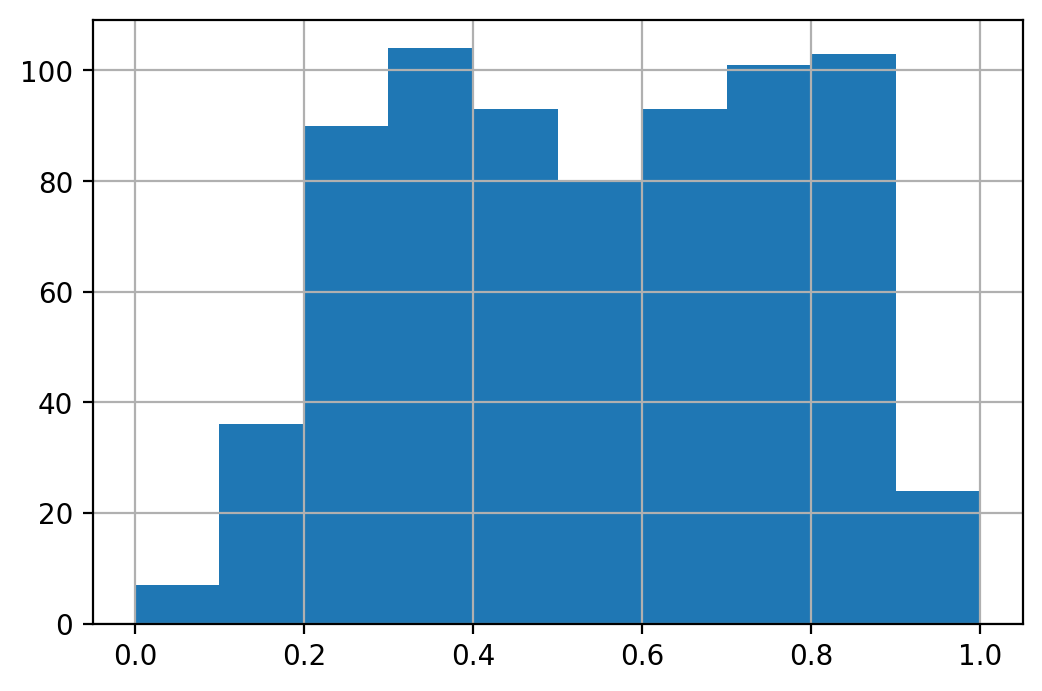

In [83]:
df['temp'].hist()

## Modeling

### Establishing Features and Target

In [84]:
features = [col for col in df.columns if col != 'cnt']
target = 'cnt'

### Linear Regression

In [85]:
import statsmodels.api as sm

X = sm.add_constant(df[features])
model = sm.OLS(df['cnt'], X)
results = model.fit()
results.params

const                         1497.148579
temp                          4175.879086
hum                          -1689.932626
windspeed                    -1381.678357
days_since_2011                  4.926432
season_SPRING                  473.715303
season_SUMMER                 -287.387420
season_WINTER                 -425.602853
holiday_NO HOLIDAY             686.115442
workingday_WORKING DAY         124.920938
weathersit_MISTY              -379.398530
weathersit_RAIN/SNOW/STORM   -1901.539915
dtype: float64

In [86]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     251.2
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          1.05e-237
Time:                        22:38:09   Log-Likelihood:                -5993.0
No. Observations:                 731   AIC:                         1.201e+04
Df Residuals:                     719   BIC:                         1.207e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1497.1486    324.587      4.612      0.000     859.897    2134.400
temp                        4175.8791    265.667     15.718      0.000    3654.304    4697.454
hum                        -1689.9326    308.226     -5.483      0.000   -2295.063   -1084.803
windspeed                  -1381.6784    223.979     -6.169      0.000   -1821.409    -941.948
days_since_2011                4.9264      0.173     28.507      0.000       4.587       5.266
season_SPRING                473.7153    109.947      4.309      0.000     257.860     689.570
season_SUMMER               -287.3874    134.225     -2.141      0.033    -550.906     -23.869
season_WINTER               -425.6029    110.820     -3.840      0.000    -643.172    -208.034
holiday_NO HOLIDAY           686.1154    203.301      3.375      0.001     286.980    1085.251
workingday_WORKING DAY       124.9209     73.267      1.705      0.089     -18.921     268.763
weathersit_MISTY            -379.3985     87.553     -4.333      0.000    -551.289    -207.508
weathersit_RAIN/SNOW/STORM -1901.5399    223.640     -8.503      0.000   -2340.605   -1462.475
==============================================================================
Omnibus:                       91.525   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.706
Skew:                          -0.719   Prob(JB):                     5.25e-43
Kurtosis:                       5.079   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Weight Plot

In [87]:
def get_model_stats(results):
    
    coef = results.params.to_dict()
    std_error = results.bse.to_dict()
    conf_intervals = results.conf_int(alpha=0.5).to_dict()

    for key, val in coef.items():
        coef[key] = [val]

    t = pd.DataFrame(coef).T
    t['std_error'] = t.index.map(std_error)
    t.columns = ['coefficients', 'std_error']
    t['lower'] = t.index.map(conf_intervals[0])
    t['upper'] = t.index.map(conf_intervals[1])
    
    return t, coef

In [88]:
t, coef = get_model_stats(results)

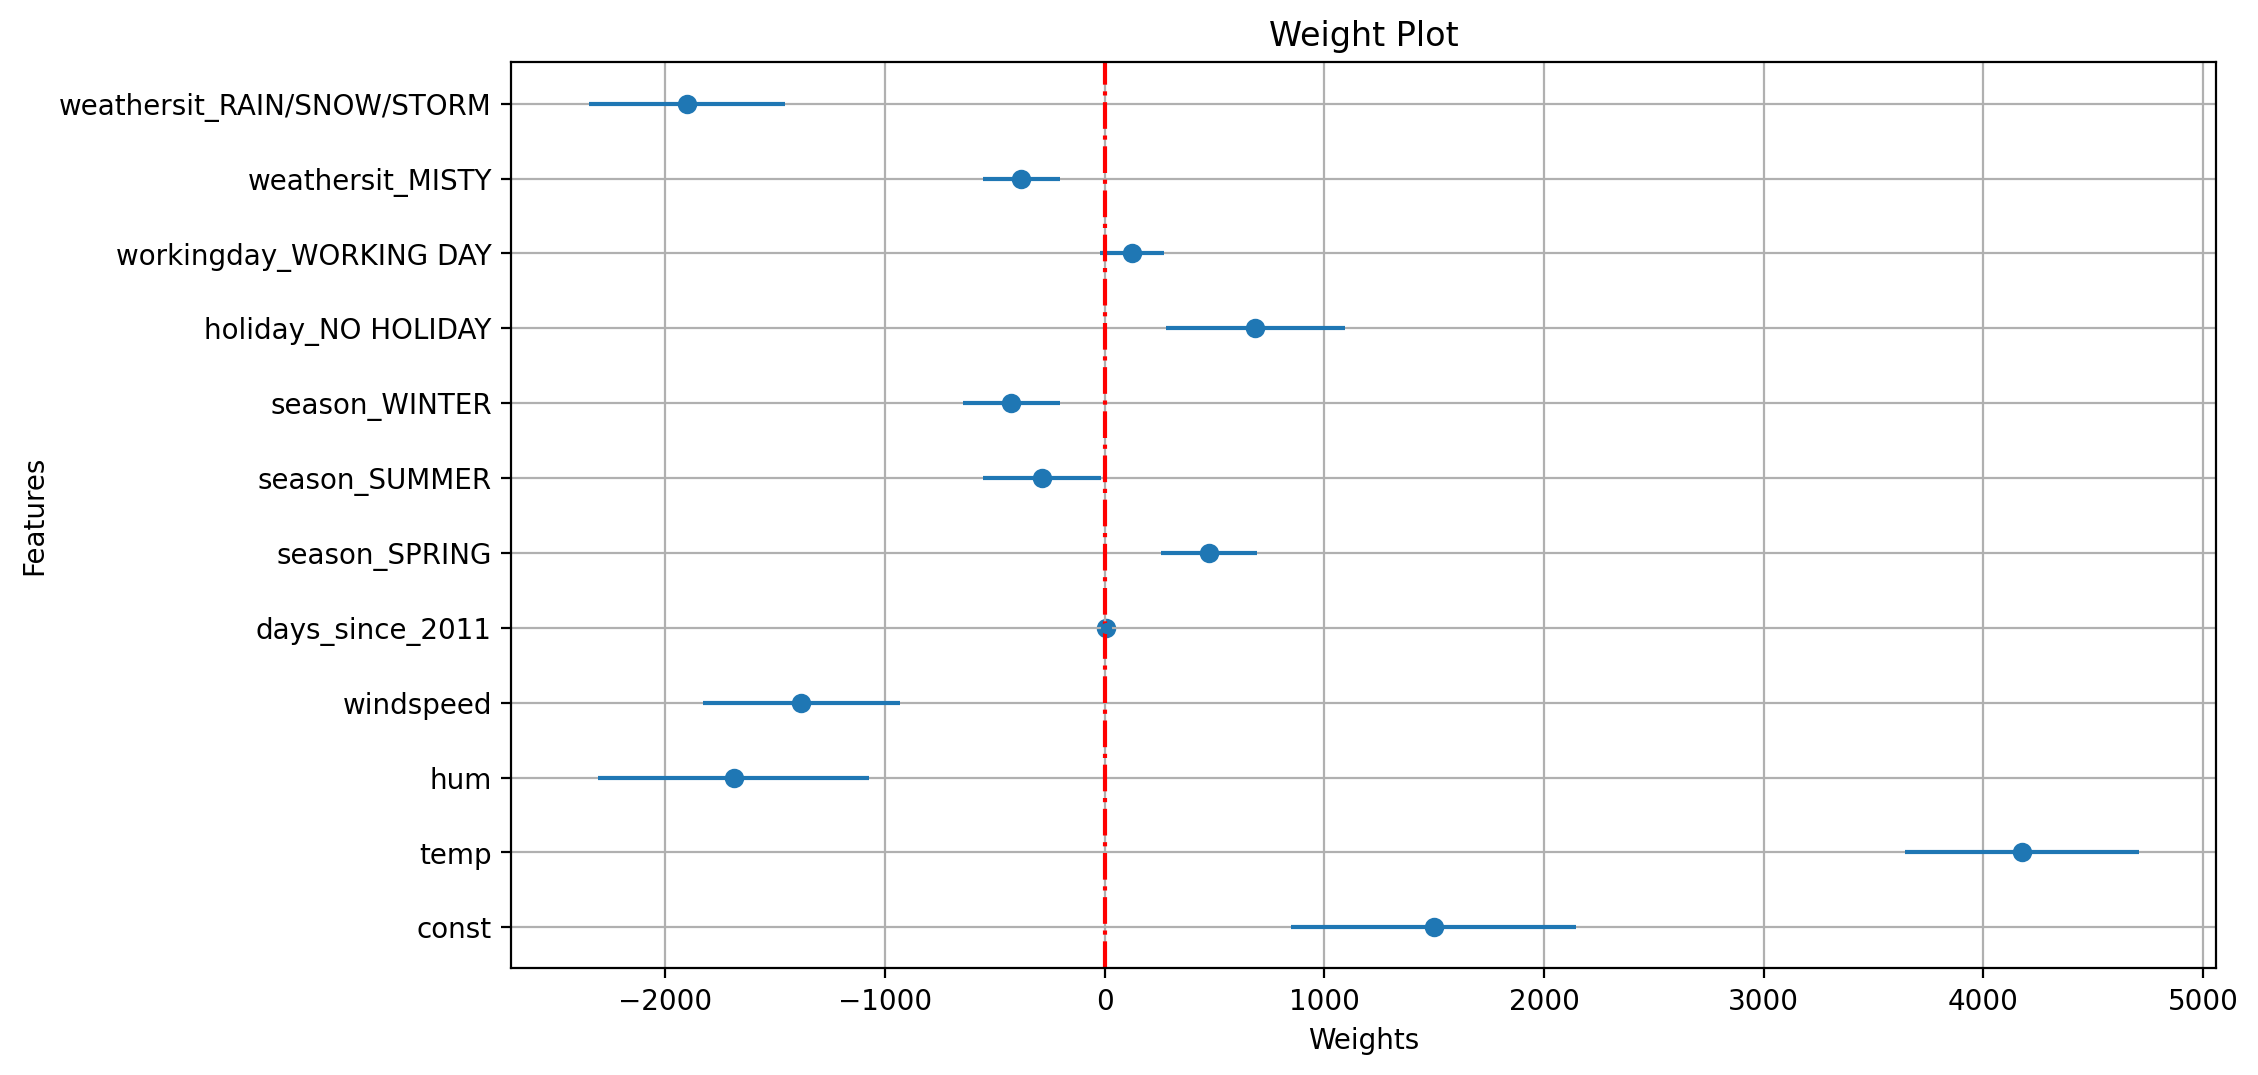

In [89]:
# Plotting the Weight Plot

plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(t['coefficients'], t.index)
ax.errorbar(t['coefficients'], t.index, xerr=2*t['std_error'], fmt = '.')
ax.axvline(0, linestyle='-.', color='red')
ax.set_title("Weight Plot")
ax.set_xlabel("Weights")
ax.set_ylabel("Features")
plt.grid('True')

The Weight Plot shows that the feature, "weathersit_RAIN/SNOW/STORM", has a strong negative effect on the bike rentals. The features, "season_WINTER", "season_SUMMER", and "workingday_WORKING DAY" have coefficients where 0 falls within its 95% confidence interval. That says that the effect is not statistically significant.

## Effect Plot
The weight plot shows how much *weight* a feature has on the prediction. BUT an effect plot helps understand how much a feature contributes to the predictions. This is done by multiplying the weight by its actual feature values. 

In [90]:
for col in [col for col in df.columns if col != 'cnt']:
    df['effect_'+col] = df[col] * coef[col][0]

In [91]:
effect_columns = [col for col in df.columns if "effect_" in col]
effect_columns

['effect_temp',
 'effect_hum',
 'effect_windspeed',
 'effect_days_since_2011',
 'effect_season_SPRING',
 'effect_season_SUMMER',
 'effect_season_WINTER',
 'effect_holiday_NO HOLIDAY',
 'effect_workingday_WORKING DAY',
 'effect_weathersit_MISTY',
 'effect_weathersit_RAIN/SNOW/STORM']

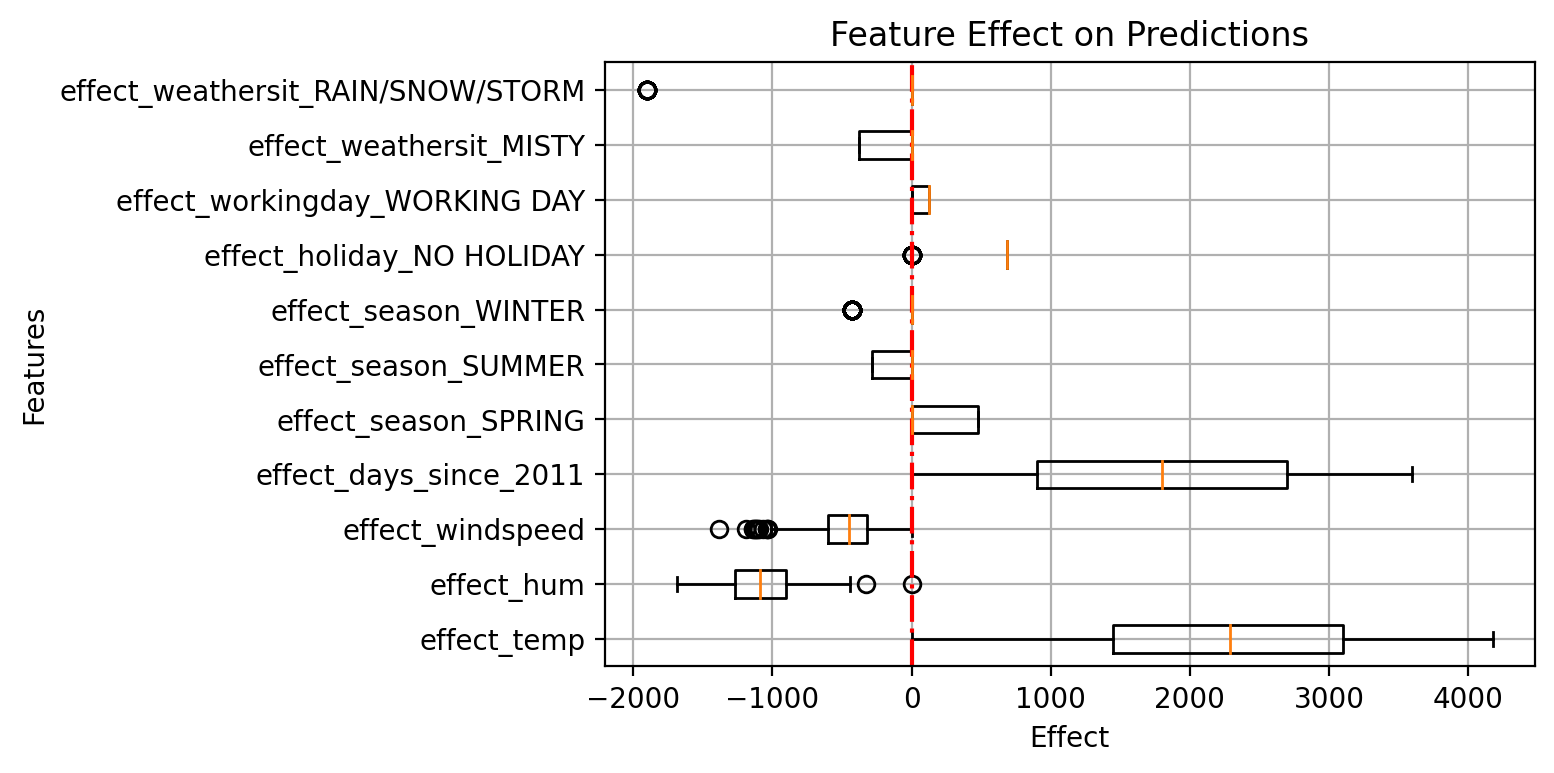

In [92]:
fig, ax = plt.subplots(1,1)

ax.boxplot(df[effect_columns], vert=False)
ax.set_yticklabels(effect_columns)
ax.axvline(0, linestyle='-.', color='red')
ax.set_ylabel("Features")
ax.set_xlabel("Effect")
ax.set_title("Feature Effect on Predictions")
plt.grid();

## Plot Individual Predictions

In [93]:
# new_observation = [1.604356, 51.8261, 6.000868, 5, 0, 0, 1, 1, 1, 0, 0]

# fig, ax = plt.subplots(1,1)
# ax.boxplot(df[effect_columns], vert=False)
# for idx, col in enumerate(effect_columns):
#     ax.annotate('x', (idx, new_observation[idx]))
# ax.set_yticklabels(effect_columns)
# ax.axvline(0, linestyle='-.', color='red')
# ax.set_ylabel("Features")
# ax.set_xlabel("Effect")
# ax.set_title("Feature Effect on Predictions")
# plt.grid();

## Interaction Effect

In [94]:
# Creating a interaction effect of workingday and temperature

df_copy['workingday_temp'] = df_copy['workingday_WORKING DAY'] * df_copy['temp']

In [95]:
interaction_columns = [col for col in df_copy.columns if col not in ['weathersit', 'workingday', 'weekday', 'cnt', 'season', 'yr', 'mnth', 'holiday']]
interaction_columns = [col for col in interaction_columns if 'effect' not in col]
interaction_columns

['temp',
 'hum',
 'windspeed',
 'days_since_2011',
 'season_SPRING',
 'season_SUMMER',
 'season_WINTER',
 'holiday_NO HOLIDAY',
 'workingday_WORKING DAY',
 'weathersit_MISTY',
 'weathersit_RAIN/SNOW/STORM',
 'workingday_temp']

In [96]:
X = sm.add_constant(df_copy[interaction_columns])
interaction_model = sm.OLS(df_copy['cnt'], X)
interaction_results = interaction_model.fit()

In [97]:
interaction_df, interaction_coef = get_model_stats(interaction_results)

In [98]:
interaction_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     232.9
Date:                Sat, 10 Dec 2022   Prob (F-statistic):          4.70e-238
Time:                        22:38:11   Log-Likelihood:                -5989.4
No. Observations:                 731   AIC:                         1.200e+04
Df Residuals:                     718   BIC:                         1.206e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1937.9905    329.281      5.886      0.000    1291.521    2584.460
temp                         125.4363      8.895     14.102      0.000     107.973     142.899
hum                          -17.5037      3.156     -5.546      0.000     -23.700     -11.307
windspeed                    -42.0682      6.864     -6.129      0.000     -55.544     -28.592
days_since_2011                4.9307      0.172     28.654      0.000       4.593       5.268
season_SPRING                467.2725    109.499      4.267      0.000     252.297     682.248
season_SUMMER               -289.4902    133.648     -2.166      0.031    -551.877     -27.103
season_WINTER               -426.5500    110.342     -3.866      0.000    -643.182    -209.918
holiday_NO HOLIDAY           674.4010    202.471      3.331      0.001     276.895    1071.907
workingday_WORKING DAY       451.8710    141.699      3.189      0.001     173.678     730.064
weathersit_MISTY            -382.1347     87.181     -4.383      0.000    -553.296    -210.974
weathersit_RAIN/SNOW/STORM -1898.2107    222.679     -8.524      0.000   -2335.390   -1461.032
workingday_temp              -21.7967      8.099     -2.691      0.007     -37.696      -5.897
==============================================================================
Omnibus:                       92.795   Durbin-Watson:                   0.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.738
Skew:                          -0.729   Prob(JB):                     1.90e-43
Kurtosis:                       5.081   Cond. No.                     4.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
temp = interaction_results.params['temp']
workingday = interaction_results.params['workingday_WORKING DAY']
working_day_temp = interaction_results.params['workingday_temp']
intercept = interaction_results.params['const']

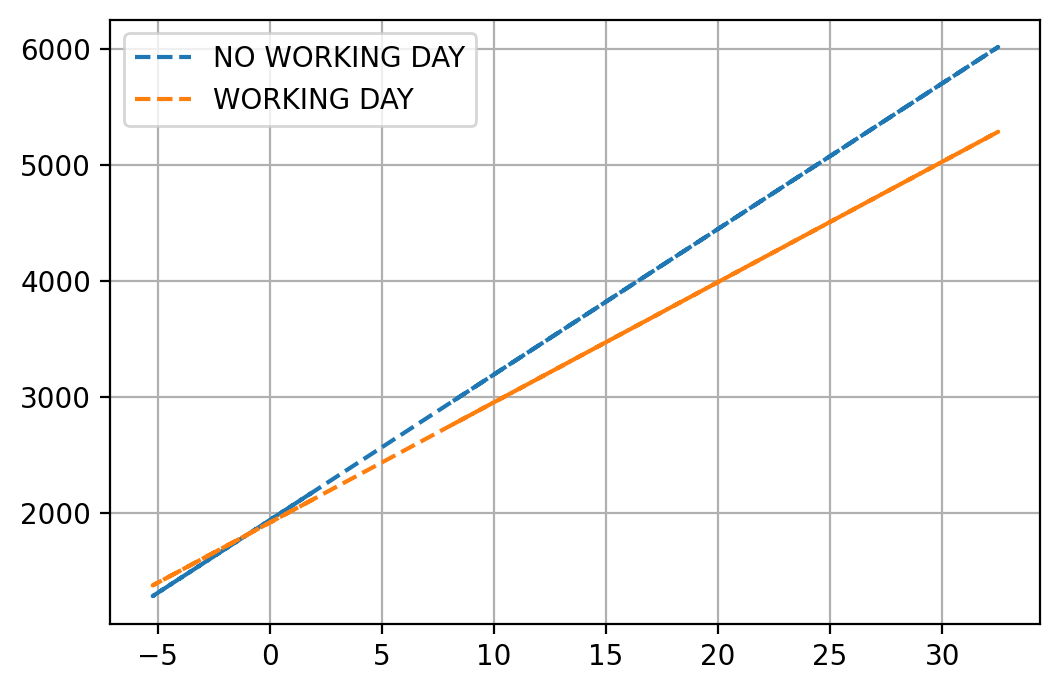

In [102]:
plt.plot(df_copy['temp'], temp*df_copy['temp'] + intercept, linestyle="--", label='NO WORKING DAY')
plt.plot(df_copy['temp'], (temp+working_day_temp)*df_copy['temp'] + (intercept + working_day_temp), linestyle="--", label='WORKING DAY')
plt.legend()
plt.grid()